In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [67]:
# load data
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


Pclass = Passenger class
SibSp = Number of Siblings/Spouses Aboard
Parch Number of Parents/Children Aboard
Fare = in British Pound
Embarked = Port of Embarkation (C = Cherbourg; Q = Queenstown; S = Southampton)

Source: http://campus.lakeforest.edu/frank/FILES/MLFfiles/Bio150/Titanic/TitanicMETA.pdf

In [68]:
# Check missing value in train_data
train_data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [69]:
# Percentage of null in Age = 0.248 = 25%
train_data["Age"].isnull().sum()/train_data["Age"].count()

0.24789915966386555

In [70]:
# Checking unique values of Age
train_data["Age"].unique()

array([22.  , 38.  , 26.  , 35.  ,   nan, 54.  ,  2.  , 27.  , 14.  ,
        4.  , 58.  , 20.  , 39.  , 55.  , 31.  , 34.  , 15.  , 28.  ,
        8.  , 19.  , 40.  , 66.  , 42.  , 21.  , 18.  ,  3.  ,  7.  ,
       49.  , 29.  , 65.  , 28.5 ,  5.  , 11.  , 45.  , 17.  , 32.  ,
       16.  , 25.  ,  0.83, 30.  , 33.  , 23.  , 24.  , 46.  , 59.  ,
       71.  , 37.  , 47.  , 14.5 , 70.5 , 32.5 , 12.  ,  9.  , 36.5 ,
       51.  , 55.5 , 40.5 , 44.  ,  1.  , 61.  , 56.  , 50.  , 36.  ,
       45.5 , 20.5 , 62.  , 41.  , 52.  , 63.  , 23.5 ,  0.92, 43.  ,
       60.  , 10.  , 64.  , 13.  , 48.  ,  0.75, 53.  , 57.  , 80.  ,
       70.  , 24.5 ,  6.  ,  0.67, 30.5 ,  0.42, 34.5 , 74.  ])

In [71]:
# Flooring all decimal numbers
train_data["Age"] = train_data["Age"].apply(np.floor)

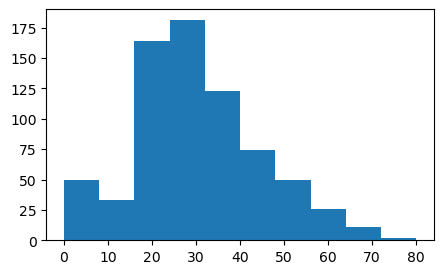

In [72]:
# Checking histogram of age (skewed)
plt.figure(figsize = (5, 3))
plt.hist(train_data["Age"])
plt.show()

In [73]:
# replace nan with median
train_data["Age"].fillna(train_data["Age"].median(skipna= True), inplace = True)